Check for targets in the doublesex gene:  
AFUN2_006316 on 2R in FunGA1  
AGAP004050 on 2R in PEST

In [1]:
import pandas as pd
import allel
import collections
import numpy as np
import malariagen_data
import gcsfs
import zarr
import dask
import dask.array as da
import cython
import functools
import os

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Exons
Get exon positions for fun and gam female isoform from vector base and compare sequence similarity to choose the sensible transcript.  
AGAP004050, female isofrom, mRNA RB in Pest, AFUN2_006316 in AFunGA

In [3]:
gam_exons = np.array([[48.703664, 48.706331], 
                    [48.711528, 48.712794],
                    [48.712957, 48.714648], 
                    [48.715161, 48.715295], 
                    [48.747693, 48.747737], 
                    [48.784185, 48.785629], 
                    [48.787046, 48.788460]])
gam_cds = np.array([[48.714557, 48.714648], 
                    [48.715161, 48.715295], 
                    [48.747693, 48.747737],
                    [48.784185, 48.784710]])

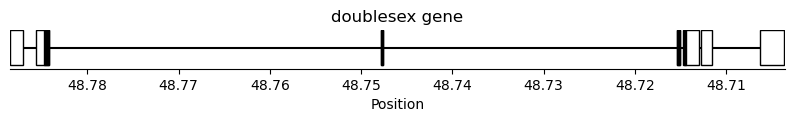

In [109]:
# Define the figure and axis
fig, ax = plt.subplots(figsize=(10,.5))

#Add line
ax.plot([gam_exons[0,0], gam_exons[-1,1]], [0.5, 0.5], 'k', zorder=1)

# plot exons as boxes 
for i, (start, end) in enumerate(gam_exons):
    width = end - start
    if width < .0003:
        width=.0003
        start = (start+end)/2-.00015
    rect = patches.Rectangle((start, 0), width, 1, edgecolor='k', facecolor='w', zorder=2)
    ax.add_patch(rect)

#plot cds as filled boxes
for i, (start, end) in enumerate(gam_cds):
    width = end - start
    if width < .0003:
        width=.0003
        start = (start+end)/2-.00015
    rect = patches.Rectangle((start, 0), width, 1, edgecolor='k', facecolor='k', zorder=3)
    ax.add_patch(rect)

    
# Set the limits of the plot
ax.set_xlim(gam_exons[-1,1], gam_exons[0,0]-.0001)
ax.set_ylim(-.1, 1)
ax.set_yticks([])

# Add labels and title
ax.set_xlabel('Position')
ax.set_ylabel('')
ax.set_title('doublesex gene')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Show the plot
plt.savefig("doublesex_exons_gam.svg")


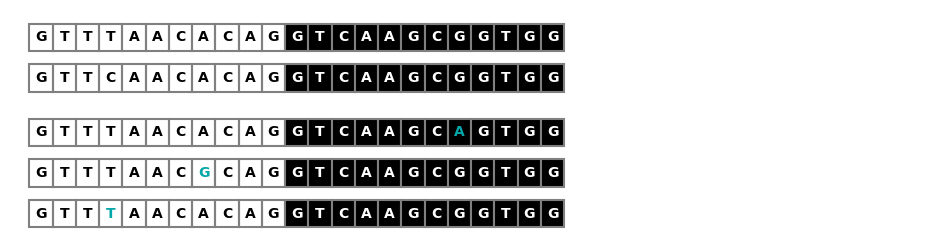

In [110]:
# Define the DNA sequences
refgam = "GTTTAACACAGGTCAAGCGGTGG"
reffun = "GTTCAACACAGGTCAAGCGGTGG"
vargam1 = "GTTTAACACAGGTCAAGCAGTGG"
vargam2 = "GTTTAACGCAGGTCAAGCGGTGG"
varfun = "GTTTAACACAGGTCAAGCGGTGG"

# Function to plot a DNA sequence
def plot_dna_sequence(ax, sequence, y_pos, width=.6, height=.4, b=11, 
                     highlightletter=-1):
    for i, letter in enumerate(sequence[:b]):
        # Draw a smaller rectangle around each letter
        rect = plt.Rectangle((i*width, y_pos), width, height, linewidth=1.5, edgecolor='grey', facecolor='none')
        ax.add_patch(rect)
        # Add the letter inside the rectangle
        if i+1 == highlightletter:
            ax.text(i*width + width/2, y_pos + height/2, letter, ha='center', va='center', fontsize=10, 
                    fontweight='bold', color='#02a7a9')
        else:
            ax.text(i*width + width/2, y_pos + height/2, letter, ha='center', va='center', fontsize=10, 
                    fontweight='bold')
    for i, letter in enumerate(sequence[b:]):
        # Draw a smaller rectangle around each letter
        rect = plt.Rectangle(((i+b)*width, y_pos), width, height, linewidth=1.5, edgecolor='grey', facecolor='black')
        ax.add_patch(rect)
        # Add the letter inside the rectangle
        if i+b+1 == highlightletter:
            ax.text((i+b)*width + width/2, y_pos + height/2, letter, ha='center', va='center', fontsize=10, 
                fontweight='bold', color='#02a7a9')
        else:
            ax.text((i+b)*width + width/2, y_pos + height/2, letter, ha='center', va='center', fontsize=10, 
                fontweight='bold', color='white')

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 3))

# Plot the first DNA sequence
plot_dna_sequence(ax, refgam, y_pos=.6)

# Plot the second DNA sequence below the first one with some vertical space
plot_dna_sequence(ax, reffun, y_pos=0)

# Plot the second DNA sequence below the first one with some vertical space
plot_dna_sequence(ax, vargam1, y_pos=-.8, highlightletter=19)

# Plot the second DNA sequence below the first one with some vertical space
plot_dna_sequence(ax, vargam2, y_pos=-1.4, highlightletter=8)

# Plot the second DNA sequence below the first one with some vertical space
plot_dna_sequence(ax, varfun, y_pos=-2, highlightletter=4)

# Set the limits of the plot
ax.set_xlim(-0.5, 23.5)
ax.set_ylim(-2.2, 1.2)

# Remove the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove the box around the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Display the plot
plt.savefig('doublesex_seq_variation.svg')


In [40]:
#Load af1 and ag3 to access reference genome
#Sequence will be read for chromosomes separately
af1 = malariagen_data.Af1(release='1.0')
ag3 = malariagen_data.Ag3(release='3.0')

In [41]:
chrom='2RL'
funseq = af1.genome_sequence(chrom)
funseq

dask.array<array, shape=(102883511,), dtype=|S1, chunksize=(803778,), chunktype=numpy.ndarray>

In [42]:
chrom = '2R'
gamseq = ag3.genome_sequence(chrom)
gamseq

dask.array<array, shape=(61545105,), dtype=|S1, chunksize=(10000000,), chunktype=numpy.ndarray>

In [45]:
gamseq[48714636:48714659].compute()

array([b'C', b'C', b'A', b'C', b'C', b'G', b'C', b'T', b'T', b'G', b'A',
       b'C', b'C', b'T', b'G', b'T', b'G', b'T', b'T', b'A', b'A', b'A',
       b'C'], dtype='|S1')

In [43]:
funseq[15613531:15613554].compute()

array([b'C', b'C', b'A', b'C', b'C', b'G', b'C', b'T', b'T', b'G', b'A',
       b'C', b'C', b'T', b'G', b'T', b'G', b'T', b'T', b'G', b'A', b'A',
       b'C'], dtype='|S1')

### Check variation

In [74]:
#check which samples are variable at this position
g = ag3.snp_calls(region='2R:48714637-48714659', sample_sets='3.0')
g

<xarray.Dataset> Size: 1MB
Dimensions:                             (variants: 23, alleles: 4,
                                         samples: 3081, ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    variant_contig                      (variants) uint8 23B dask.array<chunksize=(23,), meta=np.ndarray>
    sample_id                           (samples) <U24 296kB dask.array<chunksize=(81,), meta=np.ndarray>
Dimensions without coordinates: variants, alleles, samples, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 92B dask.array<chunksize=(23, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool 23B dask.array<chunksize=(23,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool 23B dask.array<chunksize=(23,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool 23B dask.array<chunksize=(23,), meta=np.ndarray>
    call_genotype                       (variants, samples, ploidy) int8 142kB dask.array<chunksize=(23, 50, 2), meta=np.ndarray>
    call_GQ                             (variants, samples) int16 142kB dask.array<chunksize=(23, 50), meta=np.ndarray>
    call_MQ                             (variants, samples) int16 142kB dask.array<chunksize=(23, 50), meta=np.ndarray>
    call_AD                             (variants, samples, alleles) int16 567kB dask.array<chunksize=(23, 50, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, samples, ploidy) bool 142kB dask.array<chunksize=(23, 50, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [75]:
#check that it is the exact target
g.variant_allele.compute()

<xarray.DataArray 'variant_allele' (variants: 23, alleles: 4)> Size: 92B
array([[b'C', b'A', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'C', b'A', b'T', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'A', b'C', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'T', b'A', b'C', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'T', b'A', b'C', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'C', b'A', b'T', b'G']], dtype='|S1')
Coordinates:
    variant_position  (variants) int32 92B 48714637 48714638 ... 48714659
    variant_contig    (variants) uint8 23B 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Dimensions without coordinates: variants, alleles

In [76]:
#get genotypes
calls = g.call_genotype.compute()
#sum alleles per individual
gen = calls.sum(axis=2)
print(gen.shape)
#check where there are variants
variants = (gen>0).any(axis=1)
if any(variants):
    print(variants.variant_position[variants])

(23, 3081)
<xarray.DataArray 'variant_position' (variants: 2)> Size: 8B
array([48714641, 48714652], dtype=int32)
Coordinates:
    variant_position  (variants) int32 8B 48714641 48714652
    variant_contig    (variants) uint8 2B 0 0
Dimensions without coordinates: variants


In [77]:
#individuals that carry the first variant
gen.sample_id[(gen[variants]>0)[0]]

<xarray.DataArray 'sample_id' (samples: 64)> Size: 6kB
array(['AR0061-C', 'AR0078-C', 'AR0084-C', 'AR0072-C', 'AR0083-C',
       'AR0085-C', 'AR0086-C', 'AR0057-C', 'AR0063-C', 'AR0087-C',
       'AR0065-C', 'AR0038-C', 'AR0089-C', 'AR0071-C', 'AR0023-C',
       'AR0024-C', 'AR0014-C', 'AR0079-C', 'AR0027-C', 'AR0075-C',
       'AR0077-C', 'AR0007-C', 'AR0062-C', 'AR0059-C', 'AR0048-C',
       'AR0009-C', 'AR0074-C', 'AR0052-C', 'AR0064-C', 'AR0036-C',
       'AR0001-C', 'AR0046-C', 'AR0050-Cx', 'AR0069-Cx', 'AR0013-Cx',
       'AR0026-C', 'BP0010-C', 'BP0011-C', 'BP0015-C', 'BP0047-C',
       'BP0059-C', 'BP0067-C', 'BP0079-C', 'BP0001-C', 'BP0004-C',
       'BP0006-C', 'BP0008-C', 'AN0018-C', 'AN0019-C', 'AN0032-C',
       'AN0103-C', 'AN0148-C', 'AN0155-C', 'AN0175-C', 'AN0204-C',
       'AN0296-Cx', 'AS0024-Cx', 'AS0036-C', 'AS0040-C', 'AS0044-Cx',
       'AS0045-Cx', 'AS0055-C', 'AS0059-C', 'AS0077-C'], dtype='<U24')
Coordinates:
    sample_id         (samples) <U24 6kB 'AR0061-C' 'AR0078-C' ... 'AS0077-C'
    variant_position  int32 4B 48714641
    variant_contig    uint8 1B 0
Dimensions without coordinates: samples

In [79]:
#their genotype at first the variant
calls[variants,(gen[variants]>0)[0]][0]

<xarray.DataArray 'call_genotype' (samples: 64, ploidy: 2)> Size: 128B
array([[2, 2],
       [0, 2],
       [0, 2],
       [2, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [2, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [2, 2],
       [0, 2],
       [0, 2],
       [2, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
...
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2],
       [0, 2]], dtype=int8)
Coordinates:
    variant_position  int32 4B 48714641
    variant_contig    uint8 1B 0
    sample_id         (samples) <U24 6kB 'AR0061-C' 'AR0078-C' ... 'AS0077-C'
Dimensions without coordinates: samples, ploidy

In [98]:
hets = gen.sample_id[(gen[variants]==2)[0]].values
homs = gen.sample_id[(gen[variants]==4)[0]].values

In [80]:
#individuals that carry the second variant
gen.sample_id[(gen[variants]>0)[1]]

<xarray.DataArray 'sample_id' (samples: 1)> Size: 96B
array(['AB0225-C'], dtype='<U24')
Coordinates:
    sample_id         (samples) <U24 96B 'AB0225-C'
    variant_position  int32 4B 48714652
    variant_contig    uint8 1B 0
Dimensions without coordinates: samples

In [81]:
#their genotype at the second variant
calls[variants,(gen[variants]>0)[1]][1]

<xarray.DataArray 'call_genotype' (samples: 1, ploidy: 2)> Size: 2B
array([[0, 2]], dtype=int8)
Coordinates:
    variant_position  int32 4B 48714652
    variant_contig    uint8 1B 0
    sample_id         (samples) <U24 96B 'AB0225-C'
Dimensions without coordinates: samples, ploidy

64 samples are variable, both heterozygous and homozygous, at position 48714641, or the ninteenth (1-indexed) base of the target site (rc'ed).  
There is a C-->T reference strand mutation, i.e. a G-->A rc strand mutation, in the exonic region.  
1 sample is heterozygous at position 48714652, or the eighth (1-indexed) base of the target site (rc'ed).  
There is a T-->C reference strand mutation, i.e. a A-->G rc strand mutation, in the intronic region.  

In [84]:
# check which samples are variable at this position
g = af1.snp_calls(region='2RL:15613532-15613554')
g

<xarray.Dataset> Size: 351kB
Dimensions:                       (variants: 23, alleles: 4, samples: 656,
                                   ploidy: 2)
Coordinates:
    variant_position              (variants) int32 92B dask.array<chunksize=(23,), meta=np.ndarray>
    variant_contig                (variants) uint8 23B dask.array<chunksize=(23,), meta=np.ndarray>
    sample_id                     (samples) <U36 94kB dask.array<chunksize=(36,), meta=np.ndarray>
Dimensions without coordinates: variants, alleles, samples, ploidy
Data variables:
    variant_allele                (variants, alleles) |S1 92B dask.array<chunksize=(23, 1), meta=np.ndarray>
    variant_filter_pass_funestus  (variants) bool 23B dask.array<chunksize=(23,), meta=np.ndarray>
    call_genotype                 (variants, samples, ploidy) int8 30kB dask.array<chunksize=(23, 36, 2), meta=np.ndarray>
    call_GQ                       (variants, samples) int8 15kB dask.array<chunksize=(23, 36), meta=np.ndarray>
    call_MQ                       (variants, samples) float32 60kB dask.array<chunksize=(23, 36), meta=np.ndarray>
    call_AD                       (variants, samples, alleles) int16 121kB dask.array<chunksize=(23, 36, 4), meta=np.ndarray>
    call_genotype_mask            (variants, samples, ploidy) bool 30kB dask.array<chunksize=(23, 36, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2RL', '3RL', 'X')

In [50]:
#check that it is the exact target
g.variant_allele.compute()

<xarray.DataArray 'variant_allele' (variants: 23, alleles: 4)> Size: 92B
array([[b'C', b'A', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'C', b'A', b'T', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'A', b'C', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'C', b'A', b'T', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'T', b'A', b'C', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'T', b'A', b'C', b'G'],
       [b'T', b'A', b'C', b'G'],
       [b'G', b'A', b'C', b'T'],
       [b'A', b'C', b'T', b'G'],
       [b'A', b'C', b'T', b'G'],
       [b'C', b'A', b'T', b'G']], dtype='|S1')
Coordinates:
    variant_position  (variants) int32 92B 15613532 15613533 ... 15613554
    variant_contig    (variants) uint8 23B 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Dimensions without coordinates: variants, alleles

In [52]:
#get genotypes
calls = g.call_genotype.compute()
#sum alleles per individual
gen = calls.sum(axis=2)
print(gen.shape)
#check where there are variants
variants = (gen>0).any(axis=1)
if any(variants):
    print(variants.variant_position[variants])

(23, 656)
<xarray.DataArray 'variant_position' (variants: 1)> Size: 4B
array([15613551], dtype=int32)
Coordinates:
    variant_position  (variants) int32 4B 15613551
    variant_contig    (variants) uint8 1B 0
Dimensions without coordinates: variants


In [61]:
#individuals that carry the variant
gen.sample_id[(gen[variants]>0)[0]]

<xarray.DataArray 'sample_id' (samples: 2)> Size: 288B
array(['VBS17518', 'VBS17663'], dtype='<U36')
Coordinates:
    sample_id         (samples) <U36 288B 'VBS17518' 'VBS17663'
    variant_position  int32 4B 15613551
    variant_contig    uint8 1B 0
Dimensions without coordinates: samples

In [63]:
#their genotype at the variant
calls[variants,(gen[variants]>0)[0]]

<xarray.DataArray 'call_genotype' (variants: 1, samples: 2, ploidy: 2)> Size: 4B
array([[[0, 1],
        [0, 1]]], dtype=int8)
Coordinates:
    variant_position  (variants) int32 4B 15613551
    variant_contig    (variants) uint8 1B 0
    sample_id         (samples) <U36 288B 'VBS17518' 'VBS17663'
Dimensions without coordinates: variants, samples, ploidy

Two samples, VBS17518 and VBS17663, are heterozygous at position 15613551, or the fourth (1-indexed) base of the target site (rc'ed).  
There is a G-->A reference strand mutation, i.e. a C-->T rc strand mutation.  
The individuals are from DRC_Kinshasa and Kenya_Nyanza-Prov; both have median cov 27, so they are 'reliable' samples.

### Get metadata for individuals with the variants

In [86]:
gammeta = ag3.sample_metadata(sample_sets='3.0')

In [87]:
gammeta.groupby('taxon').size()

taxon
arabiensis     368
coluzzii       705
gambiae       1473
gcx1           169
gcx3            65
unassigned     301
dtype: int64

In [89]:
gammeta.cohort_admin1_year.unique()

array(['AO-LUA_colu_2009', 'BF-09_gamb_2012', 'BF-09_colu_2012',
       'BF-09_colu_2014', 'BF-09_arab_2014', 'BF-09_gamb_2014',
       'BF-07_gamb_2004', 'CD-NU_gamb_2015', 'CF-BGF_gamb_1993',
       'CF-BGF_colu_1993', 'CF-BGF_gamb_1994', 'CF-BGF_colu_1994',
       'CI-LG_colu_2012', 'CM-ES_gamb_2009', 'CM-EN_gamb_2005',
       'CM-NO_gamb_2005', 'CM-CE_gamb_2005', 'CM-OU_gamb_2005',
       'CM-EN_colu_2005', 'CM-NO_colu_2005', 'CM-AD_gamb_2005',
       'CM-SU_gamb_2005', 'CM-CE_colu_2013', 'CM-AD_gamb_2013',
       'CM-CE_gamb_2013', 'CM-NO_arab_2013', 'CM-AD_colu_2013',
       'CM-OU_gamb_2013', 'CM-NO_colu_2013', 'CM-LT_colu_2013',
       'CM-SU_gamb_2013', 'CM-SU_colu_2013', 'MYT_gamb_2011',
       'GA-1_gamb_2000', 'GH-CP_colu_2012', 'GH-WP_colu_2012',
       'GH-AA_gamb_2012', 'GH-AA_colu_2012', 'GH-EP_gamb_2012',
       'GH-EP_colu_2012', 'GM-N_gcx1_2011', 'GM-N_colu_2011', nan,
       'GM-L_colu_2006', 'GM-N_colu_2006', 'GM-N_gcx1_2006',
       'GM-M_colu_2012', 'GM-M_gamb_20

In [99]:
gammeta.loc[(gammeta.sample_id.isin(hets)) | (gammeta.sample_id.isin(homs))].groupby('taxon').size()

taxon
coluzzii    36
gambiae     28
dtype: int64

In [100]:
gammeta.loc[(gammeta.sample_id.isin(hets)) | (gammeta.sample_id.isin(homs))].groupby('cohort_admin1_year').size()

cohort_admin1_year
AO-LUA_colu_2009    36
CD-NU_gamb_2015     11
CM-ES_gamb_2009      9
GA-1_gamb_2000       8
dtype: int64

In [105]:
#check frequencies:
gammeta.loc[gammeta.sample_id.isin(hets), 'variant'] = .5
gammeta.loc[gammeta.sample_id.isin(homs), 'variant'] = 1.
gammeta.variant = gammeta.variant.fillna(0.)
gammeta.loc[gammeta.cohort_admin1_year.isin(['AO-LUA_colu_2009', 
    'CD-NU_gamb_2015', 'CM-ES_gamb_2009', 'GA-1_gamb_2000'])].groupby(
    'cohort_admin1_year')['variant'].mean()

cohort_admin1_year
AO-LUA_colu_2009    0.259259
CD-NU_gamb_2015     0.072368
CM-ES_gamb_2009     0.014851
GA-1_gamb_2000      0.057971
Name: variant, dtype: float64

In [113]:
gammeta.query('country=="Angola" and taxon == "coluzzii"')['cohort_admin1_year'].unique()

array(['AO-LUA_colu_2009'], dtype=object)

In [114]:
gammeta.query('country=="Democratic Republic of the Congo" and taxon == "gambiae"')['cohort_admin1_year'].unique()

array(['CD-NU_gamb_2015'], dtype=object)

In [115]:
gammeta.query('country=="Cameroon" and taxon == "gambiae"')['cohort_admin1_year'].unique()

array(['CM-ES_gamb_2009', 'CM-EN_gamb_2005', 'CM-NO_gamb_2005',
       'CM-CE_gamb_2005', 'CM-OU_gamb_2005', 'CM-AD_gamb_2005',
       'CM-SU_gamb_2005', 'CM-AD_gamb_2013', 'CM-CE_gamb_2013',
       'CM-OU_gamb_2013', 'CM-SU_gamb_2013'], dtype=object)

In [119]:
gammeta.query('country=="Cameroon" and taxon == "gambiae"')['variant'].mean()

0.010817307692307692

In [116]:
gammeta.query('country=="Gabon" and taxon == "gambiae"')['cohort_admin1_year'].unique()

array(['GA-1_gamb_2000'], dtype=object)

In [120]:
gammeta.query('country=="Burkina Faso" and taxon == "gambiae"')['cohort_admin1_year'].unique()

array(['BF-09_gamb_2012', 'BF-09_gamb_2014', 'BF-07_gamb_2004'],
      dtype=object)

In [106]:
gammeta.loc[gammeta.sample_id=='AB0225-C']

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin1_quarter,cohort_admin2_year,cohort_admin2_month,cohort_admin2_quarter,variant
204,AB0225-C,BFSour 57.2,Austin Burt,Burkina Faso,Souroukoudinga,2012,7,11.238,-4.235,F,...,BF-09,Houet,gambiae,BF-09_gamb_2012,BF-09_gamb_2012_07,BF-09_gamb_2012_Q3,BF-09_Houet_gamb_2012,BF-09_Houet_gamb_2012_07,BF-09_Houet_gamb_2012_Q3,0.0


In [111]:
gammeta.groupby('taxon')['variant'].mean()

taxon
arabiensis    0.000000
coluzzii      0.029787
gambiae       0.009504
gcx1          0.000000
gcx3          0.000000
unassigned    0.000000
Name: variant, dtype: float64

In [107]:
gammeta.loc[gammeta.cohort_admin1_year== 'BF-09_gamb_2012'].shape

(99, 33)

In [122]:
gammeta.query('country=="Burkina Faso" and taxon == "gambiae"').shape

(158, 33)

In [108]:
.5/99

0.005050505050505051

In [123]:
.5/158

0.0031645569620253164